<a href="https://colab.research.google.com/github/tushar-semwal/fedperf/blob/main/Vineeth/Local_Rounds/FedMed/FederatedMedian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture output
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    path = '/content/drive/MyDrive/Colab Notebooks/OpenMined/'
    os.makedirs(path, exist_ok=True)
except:
    path = './'

## Imports

In [43]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary


# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Tue Apr 13 09:08:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 28%   50C    P2    84W / 250W |   4780MiB / 11178MiB |     37%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------

## Load the MNIST Dataset

In [44]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

In [45]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [46]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


## Visualize Data

In [47]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

In [48]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    data = data.numpy()

    target = dataset.targets[i]
    target = target.numpy()
    imshow(data)
    axis.set_title(target)


/home/vineeth/anaconda3/envs/QSGD-PT/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  after removing the cwd from sys.path.


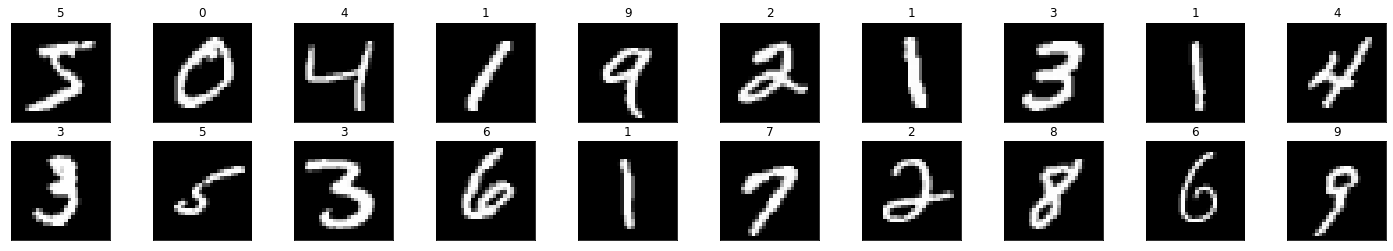

In [49]:
visualize(mnist_data_train)

/home/vineeth/anaconda3/envs/QSGD-PT/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  after removing the cwd from sys.path.


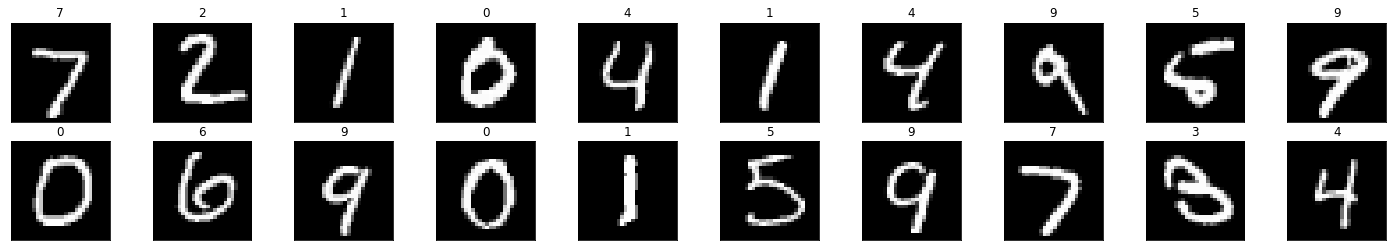

In [50]:
visualize(mnist_data_test)

## Partitioning the Data (IID and non-IID)

In [51]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [52]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict





## Models

In [53]:
class MNIST_2NN(nn.Module):
  """
  A simple multilayer-perceptron with 2-hidden layers with 200 units each
  using ReLu activations

  Total Expected Params: 199,210
  """
  def __init__(self):
    super(MNIST_2NN, self).__init__()

    self.fc1 = nn.Linear(28*28, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return x

In [54]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

### Print Model Summaries

In [55]:
mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_mlp.cuda()
  mnist_cnn.cuda()

print("MNIST MLP SUMMARY")
print(summary(mnist_mlp, (28,28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))

MNIST MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 200]          40,200
            Linear-3                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------
None

MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264

## Federated Averaging

### Local Training (Client Update)

Local training for the model on client side

In [56]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label


class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0
      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss

### Server Side Training

Following Algorithm 1 from the paper

In [57]:
def training(model, rounds, batch_size, lr, ds, ds_test, data_dict, C, K, E, plt_title, plt_color, M):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - ds_test:         Dataset used for testing
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()
  num_clients = K
  pk = np.ones(num_clients) * 1.0 / num_clients

  # training loss
  # train_accuracy = []
  train_loss = []
  test_accuracy = []
  test_loss = []


  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss = [], []

    m = max(int(C*K), 1)
    newM = max(int(M*m), 1)
    
    c = 0
    S_t = np.random.choice(range(K), m, replace=False)

    for i in range(len(S_t)):
      if c == newM:
        break
      c += 1

      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[S_t[i]])
      weights, loss = local_update.train(model=copy.deepcopy(model))
            
      for k in weights.keys():
        t = torch.Tensor(weights[k].shape).cuda()
        t.fill_(0.1)
        weights[k] = t     

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))

    for k in range(newM, len(S_t)):
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[S_t[k]])
      weights, loss = local_update.train(model=copy.deepcopy(model))
      
      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))


    ix = 0
    weights = []
    new_w = w
    for k in w[ix].keys():
      l1 = []
      for i in range(len(w)):

          # Fixed Precision
          x1 = w[i][k] * (10**3)
          
          # Flattening weight tensors to lists
          f1 = torch.flatten(x1)
          
          # Converting values to int for our streaming algo 
          f1 = list(map(int, f1))
          
          l1.append(f1)
          #print(len(f1))
          
      # Computing Median
      j = 0
      gl = []
      while j < len(l1[0]):
        nl = []
        for i in range(len(l1)):
          nl.append(l1[i][j])
        m = np.median(nl)
        gl.append(m)
        j += 1

      
      for i in range(len(gl)):
        gl[i] /= (10**3)
      
      # print(len(gl))
      
      newar = np.asarray(gl)
      newar = np.reshape(gl, w[0][k].size())
      tens = torch.from_numpy(newar)
      weights.append(tens)

      ix += 1

    k = 0
    coun = 0
    for key, value in global_weights.items():
      global_weights[key] = weights[k]
      k += 1
      coun += 1

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

    # test
    test_criterion = nn.CrossEntropyLoss()
    test_accuracy_current, test_loss_current =  testing(copy.deepcopy(model), ds_test, 128, test_criterion, num_classes, classes_test)
    test_accuracy.append(test_accuracy_current)
    test_loss.append(test_loss_current)

  end = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Train_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_accuracy)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Accuracy',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_Accuracy.jpg', format='jpg')
  plt.show()
  
  print("Training Done!")
  print("Total time taken to Train: {}\n\n".format(end-start))
  
  return model, train_loss, test_accuracy, test_loss

## Testing Loop

In [58]:
def testing(model, dataset, bs, criterion, num_classes, classes, print_info=False):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)

  if print_info:
    print("Test Loss: {:.6f}\n".format(test_loss))

    for i in range(10):
      if total_class[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
              (classes[i], 100 * correct_class[i] / total_class[i],
              np.sum(correct_class[i]), np.sum(total_class[i])))
      else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
          100. * np.sum(correct_class) / np.sum(total_class),
          np.sum(correct_class), np.sum(total_class)))
  
  return test_accuracy, test_loss

## Logger

In [59]:
log_dict = {}
NUM_REPEAT = 5

## MNIST CNN on IID

### Train


In [ ]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 1
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # data partition dictionary
  iid_dict = iid_partition(mnist_data_train, 100)
  # load model
  mnist_cnn = MNIST_CNN()

  if torch.cuda.is_available():
    mnist_cnn.cuda()

  mnist_cnn_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, mnist_data_test, iid_dict, C, K, E, "MNIST CNN on IID Dataset", "orange", 0.01)

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

Experiment Run Number:  0


### Test

In [ ]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(mnist_cnn_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

In [ ]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               }

log_dict['MNIST CNN on IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST CNN on Non IID

### Train


In [ ]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 1
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
  # load model
  mnist_cnn = MNIST_CNN()

  if torch.cuda.is_available():
    mnist_cnn.cuda()

  mnist_cnn_non_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, "MNIST CNN on Non-IID Dataset", "green", 0.01)

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [ ]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(mnist_cnn_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

In [ ]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               }

log_dict['MNIST CNN on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST MLP on IID

### Train

In [ ]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each round
  E = 1
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # dict containing different type of data partition
  data_dict = iid_partition(mnist_data_train, 100)
  # load model
  mnist_mlp = MNIST_2NN()

  if torch.cuda.is_available():
    mnist_mlp.cuda()

  mnist_mlp_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, "MNIST MLP on IID Dataset", "orange", 0.01)
  
  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [ ]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(mnist_mlp_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

In [ ]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               }

log_dict['MNIST MLP on IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST MLP on Non IID

### Train

In [ ]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)
  
  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 1
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
  # load model
  mnist_mlp = MNIST_2NN()

  if torch.cuda.is_available():
    mnist_mlp.cuda()

  mnist_mlp_non_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, "MNIST MLP on Non-IID Dataset", "green", 0.01)

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [ ]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(mnist_mlp_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

In [ ]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               }

log_dict['MNIST MLP on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## Pickle Log

In [ ]:
import pickle
 
with open(path + 'Local_Round_FedMed_1.pkl', 'wb') as file:
  pickle.dump(log_dict, file)

In [80]:
log_dict

{'MNIST CNN on IID': {'hyperparams': {'C': 0.1,
   'E': 1,
   'K': 100,
   'batch_size': 10,
   'lr': 0.05,
   'rounds': 50},
  'test_accuracy': [[85.69620253164557,
    93.29113924050633,
    95.56962025316456,
    96.32911392405063,
    96.83544303797468,
    96.83544303797468,
    97.0886075949367,
    97.34177215189874,
    97.34177215189874,
    97.59493670886076,
    98.22784810126582,
    97.72151898734177,
    98.10126582278481,
    97.84810126582279,
    98.10126582278481,
    98.22784810126582,
    98.10126582278481,
    98.10126582278481,
    98.35443037974683,
    98.35443037974683,
    98.86075949367088,
    98.86075949367088,
    98.22784810126582,
    98.73417721518987,
    98.73417721518987,
    98.73417721518987,
    98.73417721518987,
    98.86075949367088,
    98.60759493670886,
    98.86075949367088,
    99.11392405063292,
    98.73417721518987,
    98.60759493670886,
    98.86075949367088,
    99.11392405063292,
    99.11392405063292,
    99.24050632911393,
    98.

In [86]:
import pickle
 
with open(path + 'Local_Round_FedMed_1.pkl', 'rb') as file:
  log_dict = pickle.load(file)

In [87]:
print([test_acc[-1] for test_acc in log_dict['MNIST CNN on IID']['test_accuracy']])

[98.73417721518987, 98.9873417721519, 99.11392405063292, 99.11392405063292, 99.11392405063292]


In [88]:
print([test_acc[-1] for test_acc in log_dict['MNIST CNN on Non IID']['test_accuracy']])

[85.82278481012658, 80.0, 94.30379746835443, 73.0379746835443, 63.164556962025316]


In [89]:
print([test_acc[-1] for test_acc in log_dict['MNIST MLP on IID']['test_accuracy']])

[96.9620253164557, 96.70886075949367, 95.9493670886076, 96.58227848101266, 96.83544303797468]


In [90]:
print([test_acc[-1] for test_acc in log_dict['MNIST MLP on Non IID']['test_accuracy']])

[58.734177215189874, 54.177215189873415, 51.392405063291136, 67.9746835443038, 72.27848101265823]


In [85]:
output.show()